In [25]:
import cv2
import glob
import copy
import math
import numpy as np
import imageio
import matplotlib.pyplot as plt
from pprint import pprint as pp
import pickle

In [26]:
def load_images(filenames):
    return [imageio.imread(filename) for filename in filenames]

In [27]:
filenames = list(sorted(glob.glob("left/*.jpg")))
imgs = load_images(filenames)

C:\Users\HiteshKadam\AppData\Local\Temp\ipykernel_10492\3789968186.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


In [28]:
# We will execute findChessboardCorners for each image to find the corners
corners = [cv2.findChessboardCorners(i, (7,6)) for i in imgs]

In [29]:
# OPTIONAL => cornerSubPix is a destructive function. so we need to copy corners to avoid data loss
corners2 = copy.deepcopy(corners)

# termination criteria (https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
# Cada una de las imagenes la volvemos a blanco y negro
imgs_grey = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]
# For each image and corners we are going to use cornerSubPix
cornersRefined = [cv2.cornerSubPix(i, cor[1], (7, 6), (-1, -1), criteria) if cor[0] else [] for i, cor in zip(imgs_grey, corners2)]
# pp(cornersRefined)

In [30]:
# OPTIONAL => drawChessboardCorners is a destructive function. so we need to copy corners to avoid data loss
imgs2 = copy.deepcopy(imgs)

# We are going to draw the corners if we have found them
tmp = [cv2.drawChessboardCorners(img, (8,6), cor[1], cor[0]) for img, cor in zip(imgs2, corners) if cor[0]]

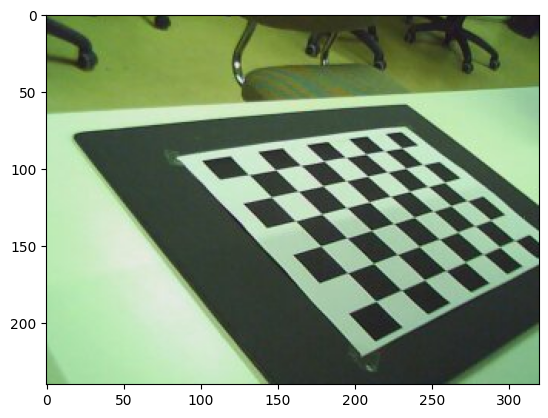

In [31]:
# Original Image
plt.figure()
plt.imshow(imgs2[0])

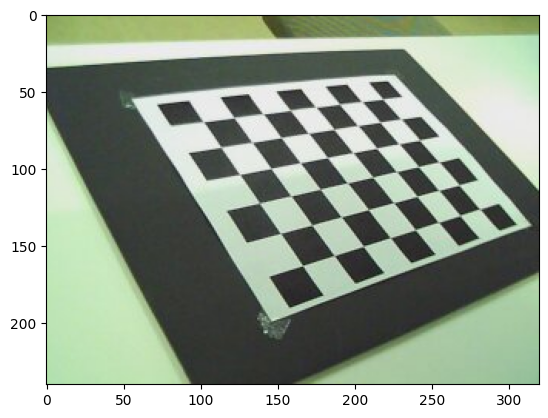

In [32]:
# Image with the corners drawed
plt.figure()
plt.imshow(imgs2[5])

In [33]:
def get_chessboard_points(chessboard_shape, dx, dy):
    return [[(i%chessboard_shape[0])*dx, (i//chessboard_shape[0])*dy, 0] for i in range(np.prod(chessboard_shape))]

cb_points = get_chessboard_points((8, 6), 30, 30)
# pp(cb_points)

In [34]:
# We are going to retrieve existing corners (cor[0] == True)
valid_corners = [cor[1] for cor in corners if cor[0]]

num_valid_images = len(valid_corners)

# Matrix with the coordinates of the corners
real_points = get_chessboard_points((8, 6), 30, 30)

# We are going to convert our coordinates list in the reference system to numpy array
object_points = np.asarray([real_points for i in range(num_valid_images)], dtype=np.float32)

# Convert the corners list to array
image_points = np.asarray(valid_corners, dtype=np.float32)

# Calibrate
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, imgs[1].shape[0:2], None, None)
# Calculate extrinsecs matrix using Rodigues on each rotation vector addid its translation vector
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))
# Save the calibration file
np.savez('calib_left', intrinsic=intrinsics, extrinsic=extrinsics)

# Lets print some outputs
print("Corners standard intrinsics:\n",intrinsics)
print("Corners standard dist_coefs:\n", dist_coeffs)
print("rms:\n", rms)

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\calibration.cpp:3752: error: (-215:Assertion failed) nimages > 0 in function 'cv::calibrateCameraRO'


In [35]:
def py_ang(v1, v2):
    # Returns the angle in radians between vectors 'v1' and 'v2'
    cosang = np.dot(v1, v2)
    sinang = np.linalg.norm(np.cross(v1, v2))
    return np.arctan2(sinang, cosang)

v1 = np.matmul(np.linalg.inv(intrinsics), [10,10,1])
v2 = np.matmul(np.linalg.inv(intrinsics), [60,60,1])

pp("Diagonal FOV: {} degrees".format(math.degrees(py_ang(v1,v2))))

NameError: name 'intrinsics' is not defined

In [36]:
# Define the chess board rows and columns
rows = 7
cols = 6

# Set the termination criteria for the corner sub-pixel algorithm
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 30, 0.001)

# Prepare the object points: (0,0,0), (1,0,0), (2,0,0), ..., (6,5,0). They are the same for all images
objectPoints = np.zeros((rows * cols, 3), np.float32)
objectPoints[:, :2] = np.mgrid[0:rows, 0:cols].T.reshape(-1, 2)

# Create the arrays to store the object points and the image points
objectPointsArray = []
imgPointsArray = []

# Loop over the image files
for path in glob.glob('my images/*.jpg'):
    # Load the image and convert it to gray scale
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (rows, cols), None)

    # Make sure the chess board pattern was found in the image
    if ret:
        # Refine the corner position
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        
        # Add the object points and the image points to the arrays
        objectPointsArray.append(objectPoints)
        imgPointsArray.append(corners)

        # Draw the corners on the image
        cv2.drawChessboardCorners(img, (rows, cols), corners, ret)
    
    # Display the image
    cv2.imshow('chess board', img)
    cv2.waitKey(500)

# Calibrate the camera and save the results
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPointsArray, imgPointsArray, gray.shape[::-1], None, None)
np.savez('calib.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

# Print the camera calibration error
error = 0

for i in range(len(objectPointsArray)):
    imgPoints, _ = cv2.projectPoints(objectPointsArray[i], rvecs[i], tvecs[i], mtx, dist)
    error += cv2.norm(imgPointsArray[i], imgPoints, cv2.NORM_L2) / len(imgPoints)

print("Total error: ", error / len(objectPointsArray))

# Load one of the test images
img = cv2.imread('my images/left12.jpg')
h, w = img.shape[:2]

# Obtain the new camera matrix and undistort the image
newCameraMtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
undistortedImg = cv2.undistort(img, mtx, dist, None, newCameraMtx)

# Crop the undistorted image
# x, y, w, h = roi
# undistortedImg = undistortedImg[y:y + h, x:x + w]

# Display the final result
cv2.imshow('chess board', np.hstack((img, undistortedImg)))
cv2.waitKey(0)
cv2.destroyAllWindows()

Total error:  0.023686000375385676


In [37]:
# This function draws lines joining the given image points to the first chess board corner
def draw(img, corners, imgPoints):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgPoints[0].ravel()), (255, 0, 0), 5)
    img = cv2.line(img, corner, tuple(imgPoints[1].ravel()), (0, 255, 0), 5)
    img = cv2.line(img, corner, tuple(imgPoints[2].ravel()), (0, 0, 255), 5)
    return img

# Load the camera calibration data
with np.load('calib.npz') as calibData:
    mtx, dist, rvecs, tvecs = [calibData[i] for i in ('mtx', 'dist', 'rvecs', 'tvecs')]

# Define the chess board rows and columns
rows = 7
cols = 6

# Set the termination criteria for the corner sub-pixel algorithm
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 30, 0.001)

# Prepare the object points: (0,0,0), (1,0,0), (2,0,0), ..., (6,5,0). They are the same for all images
objectPoints = np.zeros((rows * cols, 1, 3), np.float32)
objectPoints[:, :, :2] = np.mgrid[0:rows, 0:cols].T.reshape(-1, 1, 2)

# Create the axis points
axisPoints = np.float32([[3, 0, 0], [0, 3, 0], [0, 0, -3]]).reshape(-1, 3)

# Loop over the image files
for path in glob.glob('my images/*.jpg'):
    # Load the image and convert it to gray scale
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (rows, cols), None)

    # Make sure the chess board pattern was found in the image
    if ret:
        # Refine the corner position
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        # Find the rotation and translation vectors
        val, rvecs, tvecs, inliers = cv2.solvePnPRansac(objectPoints, corners, mtx, dist)

        # Project the 3D axis points to the image plane
        axisImgPoints, jac = cv2.projectPoints(axisPoints, rvecs, tvecs, mtx, dist)
        
        # Draw the axis lines
        img = draw(img, corners, axisImgPoints)
    
    # Display the image
    cv2.imshow('chess board', img)
    cv2.waitKey(0)

cv2.destroyAllWindows()

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
